# xgboost

In [1]:
import numpy as np
import pandas as pd
import gc
import pickle
import time

from xgboost import XGBRegressor

In [2]:
data = pd.read_pickle('feature_matrix.pickle')
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del data
gc.collect();

In [3]:
ts = time.time()

model = XGBRegressor(
    max_depth=15,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    colsample_bylevel=0.8, 
    subsample=0.8, 
    eta=0.3, 
    num_round=1000,
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[0]	validation_0-rmse:1.11632
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.07028
[2]	validation_0-rmse:1.034
[3]	validation_0-rmse:1.00508
[4]	validation_0-rmse:0.981714
[5]	validation_0-rmse:0.964345
[6]	validation_0-rmse:0.949699
[7]	validation_0-rmse:0.93979
[8]	validation_0-rmse:0.931445
[9]	validation_0-rmse:0.9234
[10]	validation_0-rmse:0.917437
[11]	validation_0-rmse:0.91169
[12]	validation_0-rmse:0.907393
[13]	validation_0-rmse:0.903986
[14]	validation_0-rmse:0.901748
[15]	validation_0-rmse:0.899988
[16]	validation_0-rmse:0.897882
[17]	validation_0-rmse:0.895267
[18]	validation_0-rmse:0.893658
[19]	validation_0-rmse:0.891917
[20]	validation_0-rmse:0.890578
[21]	validation_0-rmse:0.889706
[22]	validation_0-rmse:0.889301
[23]	validation_0-rmse:0.888512
[24]	validation_0-rmse:0.887794
[25]	validation_0-rmse:0.88807
[26]	validation_0-rmse:0.888265
[27]	validation_0-rmse:0.888465
[28]	validation_0-rmse:0.887693
[29]	validation_0-rmse:0.888

29882.184415102005

In [7]:
# model = pickle.load(open('xgb_model.pickle', 'rb'))

In [9]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [10]:
pickle.dump(model, open('xgb_model.pickle', 'wb'))
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

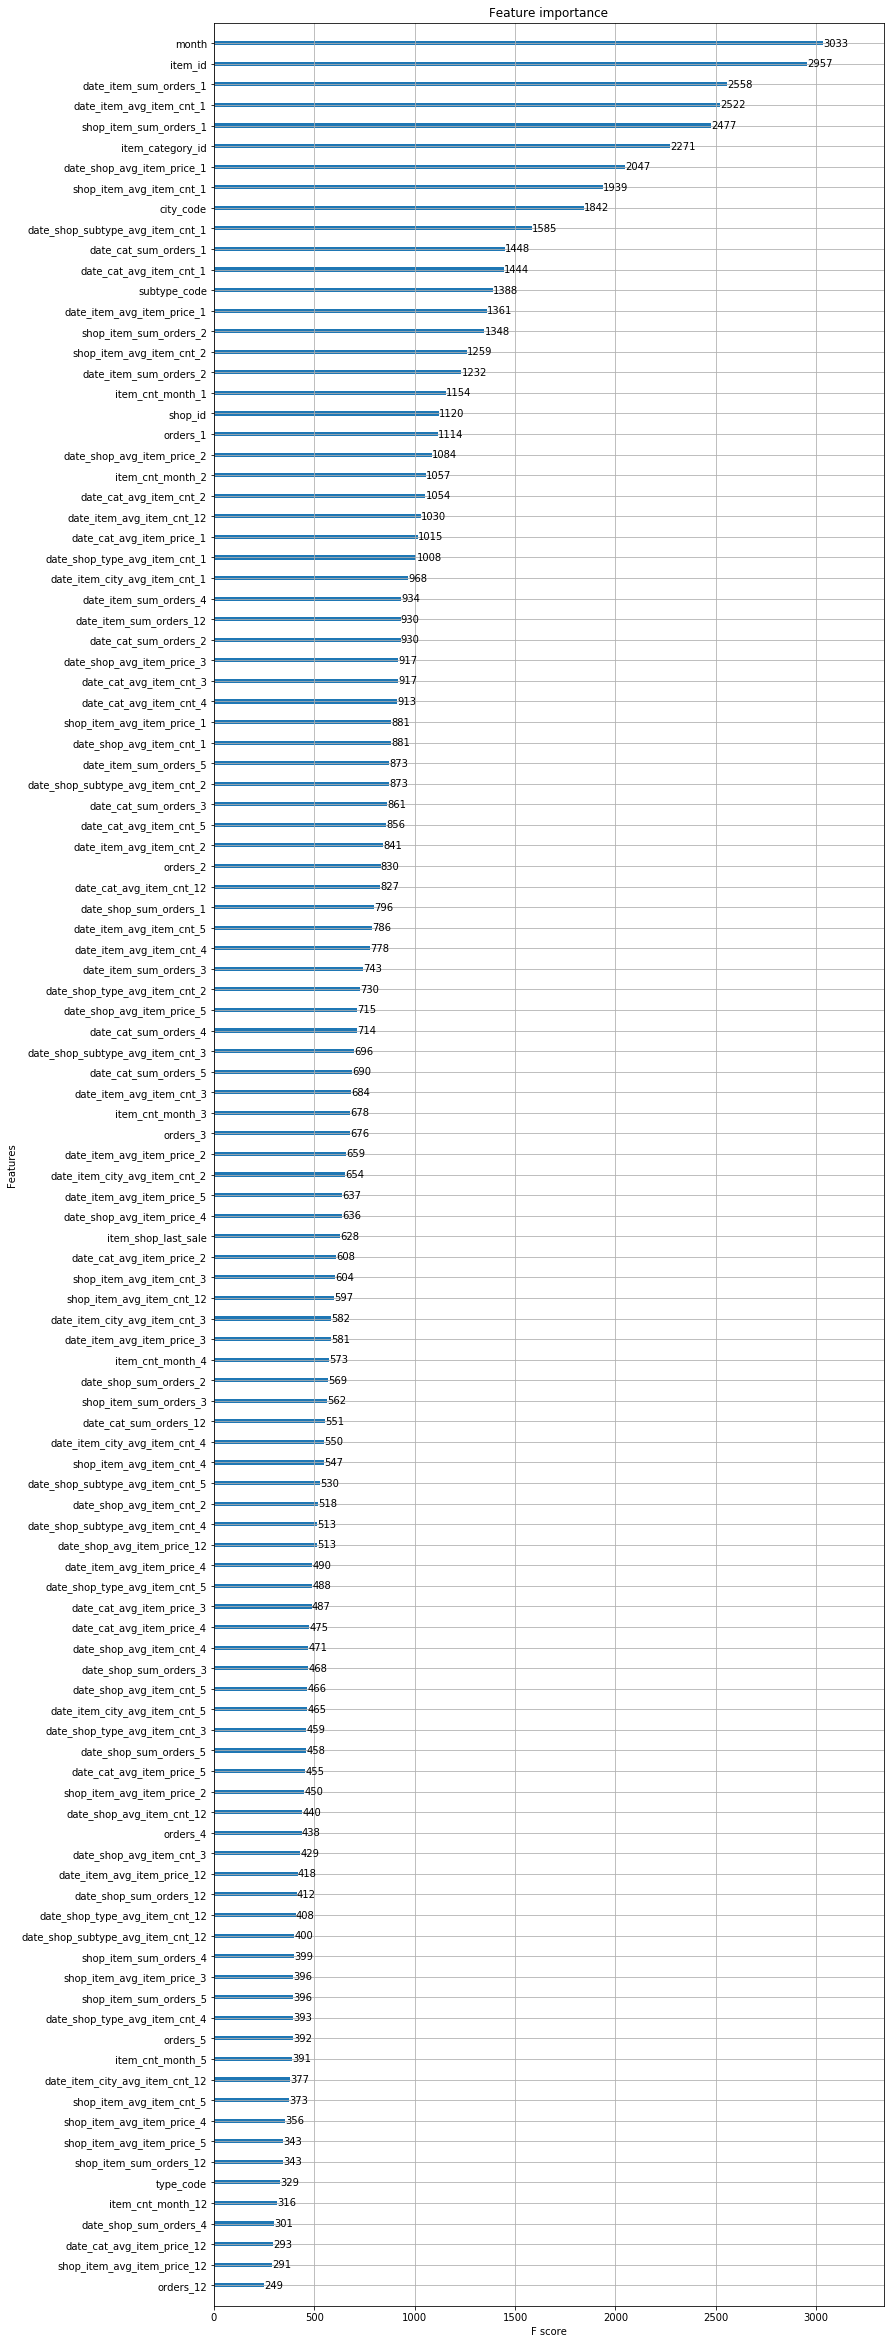

In [14]:
from xgboost import plot_importance

import matplotlib.pyplot as plt
%matplotlib inline

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (12,42))

In [12]:
test = pd.read_csv('test.csv.gz', compression='gzip').set_index('ID')
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('rf_submission.csv', index=False)

LB: 0.96734